[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ecotrust/TreeForCaSt/blob/main/notebooks/Tutorial%201%20-%20Exploring%20TreeForCaSt%20STAC.ipynb)

# Exploring TreeForCaSt STAC
A brief tour of the TreeForCaSt Spatio-Temporal Asset Catalog (STAC). 

This notebook will step you through how to:  
  * Load the TreeForCaSt STAC
  * Load a specific Collection of plots and explore the metadata
  * Visualize data from individual plots
  * Filter the STAC for plots based on the type of data they have
  * Select and fetch data from the STAC into a local directory, and  
  * Create a local replica of the STAC with downloaded data

If you would like to peruse the TreeForCaSt STAC before getting your feet wet with this notebook, you can browse the 
[TreeForCaSt STAC](https://radiantearth.github.io/stac-browser/#/external/fbstac-stands.s3.amazonaws.com/plots/catalog/catalog.json) thanks to the [stac-browser](https://github.com/radiantearth/stac-browser) produced by Radiant Earth.

## Contents:
0. [Import required packages](#Import-required-packages)
1. [Load catalog](#Load-catalog)
2. [Load a plot collection and explore the metadata](#load-forest-plot-collection)
3. [Visualize plots and source data](#visualize-forest-plots)
4. [Filter plots by data availability](#filter-forest-plots)
5. [Download source data (assets)](#download-source-data)


## 0. Install and import required libraries <a class="anchor" id="Import-required-packages"></a>

If you are running this notebook in Google Colab, uncomment and execute the following cell to install a few packages including some helper functions we've written.

In [1]:
# %pip install pystac folium wget git+https://github.com/Ecotrust/fbstac_plots.git

Import the packages and functions we'll use to explore TreeForCaSt STAC

In [2]:
import os
from pathlib import Path

import folium
import seaborn as sns
import geopandas as gpd
import shapely.geometry as Geometry
from pystac import Item, Catalog, CatalogType
import pystac

from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.notebook import tqdm

print("PySTAC", pystac.__version__)

from IPython.display import display, Markdown, Image

PySTAC 1.8.4


In [3]:
from src.explore import (
    get_item_assets,
    download_assets,
    has_datasets,
    update_href,
    count_sources,
)

## Load the Catalog  <a class="anchor" id="Load-catalog"></a>
TreeForCaSt STAC data are stored in a public bucket on AWS.

In [4]:
root_catalog = Catalog.from_file(
    "https://fbstac-stands.s3.amazonaws.com/plots/catalog/catalog.json"
)

In [5]:
# Print some basic metadata about the Catalog
print(f"ID: {root_catalog.id}")
print(f"Title: {root_catalog.title or 'N/A'}")
print(f"Description: {root_catalog.description or 'N/A'}")

ID: fbstac-plots
Title: Forest plots STAC for benchmarking and modeling.
Description: Oregon and Washington State forest plots, attributes, and imagery STAC for forest benchmarking and modeling.


### Collections within the STAC
TreeForCaSt is organized into several "collections" of data. Given the intended use of this STAC for Computer Vision and Machine Learning applications, we follow the pattern of defining collections corresponding to their use in predictive modeling as either "features" or "labels".  

**Feature collections**  
These are the collections of data that you would generally use as inputs to a predictive model. We include collections of several remote sensing datasets and formats that coincide with the field-measured plots including: NAIP, Landsat 8, lidar point clouds, lidar-derived rasters, a Digital Elevation Model (DEM), and DEM-derived topographic metrics.

**Label collections**  
These are the collections of data representing the "targets" or "labels" that you will be trying to predict (i.e., field-observed forest attributes). We have compiled several collections of field data recorded by the US Forest Service, Bureau of Land Management, and Washington Department of Natural Resources covering forests across Washington and Oregon.

As you will see illustrated further below,  each item in a Label collection (i.e., an individual forest plot) is linked to corresponding items in the Feature collections, and all items come with a variety of metadata.

In [6]:
collections = list(root_catalog.get_collections())

print("Number of collections:", len(collections))
print("Field plot (label) collection IDs:")
plot_collection_ids = []
dataset_collection_ids = []
for c in collections:
    is_plot = c.id.endswith("plots")
    if is_plot:
        plot_collection_ids.append(c.id)
        print("-", c.id)

print("Feature dataset collection IDs:")
for c in collections:
    is_plot = c.id.endswith("plots")
    if not is_plot:
        dataset_collection_ids.append(c.id)
        print("-", c.id)

Number of collections: 17
Field plot (label) collection IDs:
- blm-coos-plots
- blm-lane-plots
- blm-rogue-plots
- wa-dnr-plots
- usfs-blue-mountains-plots
- usfs-fremont-winema-plots
- usfs-gifford-pinchot-plots
- usfs-mount-baker-snoqualmie-plots
- usfs-rogue-plots
- usfs-umpqua-plots
- usfs-wenatchee-plots
Feature dataset collection IDs:
- 3dep
- naip
- lidar-rast
- 3dep-dtm
- landsat8
- lidar


## Load a collection of field plots <a class="anchor" id="load-forest-plot-collection"></a>
As an example, we will get a single label collection corresponding to a survey of forest plots collected by the US Forest Service covering the National Forests in the Blue Mountains region of northeastern Oregon.

In [7]:
fplots = root_catalog.get_child("usfs-blue-mountains-plots")
fplots

<Collection id=usfs-blue-mountains-plots>

The collection description is also compatible with Markdown syntax, which makes it easier to see metadata about the field survey, including links to the survey protocol and a database containing the raw field data we collected from the agency.

In [8]:
display(Markdown(f"## {fplots.id}\n\n{fplots.description}"))

## usfs-blue-mountains-plots

Forest plots from the US Forest Service Blue Mountains National Forest.


Additional resources:
- [Plot Survey Field Procedures](https://fbstac-stands.s3.amazonaws.com/plots/documents/USFS_2018_Region_6_LiDAR_Field_Plot_Procedures_V2.pdf)
- [Plot Survey Raw Database](https://fbstac-stands.s3.amazonaws.com/plots/raw/usfs/FVS_Data.sqlite)


We can retrieve all the individual items (field plots) from the collection.

In [11]:
items = list(fplots.get_items())  # this might take a while
print(f"Number of items: {len(items)}")

Number of items: 2445


In [12]:
item = items[0]
item.id

'3ca58372_2021_usfs-blue-mountains-label'

Each item comes with a variety of metadata.

In [13]:
item.collection_id

'usfs-blue-mountains-plots'

In [14]:
item.datetime

datetime.datetime(2021, 1, 1, 0, 0, tzinfo=tzutc())

In [15]:
item.bbox

[-121.13873118831786, 43.4732557147189, -121.13724828051431, 43.47433566415578]

We have summarized many plot-level forest attributes that we calculated using the Forest Vegetation Simulator and combined these with a geospatial "feature" which depicts the footprint of the plot as a Polygon. These attributes are stored in GeoJSON format, which allows us to easily bring the data into Python using GeoPandas. 

In [16]:
item.stac_extensions

['https://stac-extensions.github.io/label/v1.0.1/schema.json']

In [17]:
item_g = gpd.GeoDataFrame.from_features(item.geometry["features"])
item_g.T

0
geometry                 POLYGON ((-121.13724828051431 43.4732557147189...
tpa                                                                     12
ba                                                                      23
sdi                                                                     33
ccf                                                                     17
qmd                                                              18.947544
tcuft                                                                  887
topht                                                                   56
number_of_strata                                                         1
total_cover                                                              7
structure_class                                                       5=OS
canopy_baseheight                                                       25
canopy_bulkdensity                                                0.006965
aboveground_biomass                                                     18
aboveground_carbon                                                       8
aboveground_live_carbon                                                  8
gs_tpa                                                                  12
lat                                                              43.473796
lon                                                             -121.13799
orig_id                                                    060105040480258
source                                                 USFS-BLUE-MOUNTAINS
meas_yr                                                               2015
ecoregion3                           eastern_cascades_slopes_and_foothills
agency                                                                USFS
plot_size_ac                                                          0.25
bulk_dens                                                               87
soil_depth                                                           152.0
pct_clay_surf                                                            4
pct_rock_surf                                                            9
pct_sand_surf                                                           77
distance_to_water_m                                            4807.839359
pot_veg_type                                                          1053
epsg                                                                 32610
utm_x                                                        650599.511325
utm_y                                                       4815115.160085
utm_xmin                                                     650539.511325
utm_ymin                                                    4815055.160085
utm_xmax                                                     650659.511325

Each field plot item includes links which refer to the corresponding items in the remote sensing data collections. 

In [18]:
sources = [link.absolute_href for link in item.links if link.rel == "source"]
sources

['https://fbstac-stands.s3.amazonaws.com/plots/catalog/3dep/3ca58372_USFS_3DEP_1mDEM/3ca58372_USFS_3DEP_1mDEM.json',
 'https://fbstac-stands.s3.amazonaws.com/plots/catalog/naip/3ca58372_2022_USFS-BLUE-MOUNTAINS_NAIP_DOQQ/3ca58372_2022_USFS-BLUE-MOUNTAINS_NAIP_DOQQ.json',
 'https://fbstac-stands.s3.amazonaws.com/plots/catalog/3dep-dtm/3ca58372_USFS_3DEP_10mDEM-DTM/3ca58372_USFS_3DEP_10mDEM-DTM.json',
 'https://fbstac-stands.s3.amazonaws.com/plots/catalog/landsat8/3ca58372_2021_USFS-BLUE-MOUNTAINS_Landsat8_leafon/3ca58372_2021_USFS-BLUE-MOUNTAINS_Landsat8_leafon.json']

We can access the corresponding items using these links.

In [19]:
linked_items = [Item.from_file(source) for source in sources]
linked_items

[<Item id=3ca58372_USFS_3DEP_1mDEM>,
 <Item id=3ca58372_2022_USFS-BLUE-MOUNTAINS_NAIP_DOQQ>,
 <Item id=3ca58372_USFS_3DEP_10mDEM-DTM>,
 <Item id=3ca58372_2021_USFS-BLUE-MOUNTAINS_Landsat8_leafon>]

In [20]:
linked_item = linked_items[1]

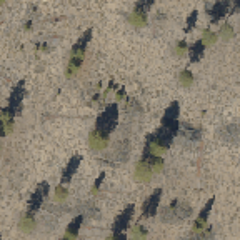

In [21]:
Image(linked_item.assets["thumbnail"].href)

In [22]:
# This is a slower way to fetch linked items
# linked_items = [root_catalog.get_item(s, recursive=True) for s in sources]
# linked_item = root_catalog.get_item(sources[1], recursive=True)

# This is also very slow
# assets = linked_item.get_assets()

## Visualize forest plots and source data <a class="anchor" id="visualize-forest-plots"></a> 

In [23]:
plot_features = [
    item.geometry["features"][0] for item in items  # if item.datetime.year == 2019
]
plot_ids = [item.id.split("_")[0] for item in items]
label_years = [item.datetime.year for item in items]
gdf = gpd.GeoDataFrame.from_features(plot_features)
gdf.insert(0, "label_year", label_years)
gdf.insert(0, "plot_id", plot_ids)

gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2445 entries, 0 to 2444
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   plot_id                  2445 non-null   object  
 1   label_year               2445 non-null   int64   
 2   geometry                 2445 non-null   geometry
 3   tpa                      2445 non-null   int64   
 4   ba                       2445 non-null   int64   
 5   sdi                      2445 non-null   int64   
 6   ccf                      2445 non-null   int64   
 7   qmd                      2445 non-null   float64 
 8   tcuft                    2445 non-null   int64   
 9   topht                    2445 non-null   int64   
 10  number_of_strata         2445 non-null   int64   
 11  total_cover              2445 non-null   int64   
 12  structure_class          2445 non-null   object  
 13  canopy_baseheight        2445 non-null   int64   
 14  

In addition to the attributes summarized from the time of initial field measurement, we have also simulated the annual growth of the plot forward through time to allow us to match these forest attributes with additional remote sensing data layers. 

This means each field plot may have multiple label items associated with it for each year the plot was grown forward. 

In [24]:
gdf.groupby(by=["meas_yr", "label_year"])["plot_id"].nunique()

meas_yr  label_year
2015     2014           96
         2015          261
         2016          261
         2017          261
         2018          261
         2019          261
         2020          261
         2021          261
         2022          261
         2023          261
Name: plot_id, dtype: int64

We can see how the simulation of plots evolve their initial measurement over time

<Axes: xlabel='label_year', ylabel='topht'>

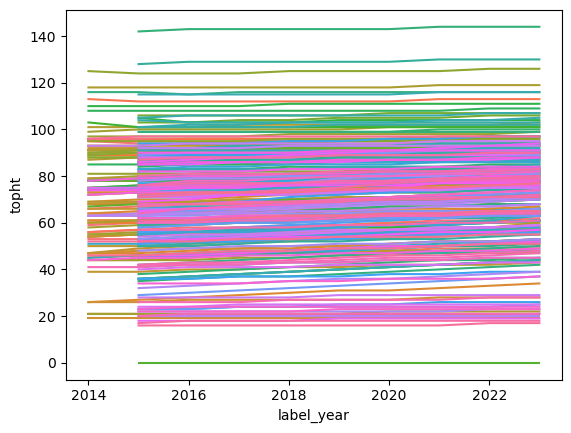

In [25]:
sns.lineplot(data=gdf, x="label_year", y="topht", hue="plot_id", legend=False)

To map the plots, we only need one polygon per plot footprint, so we can drop records after the first year for mapping purposes.

In [26]:
gdf.drop_duplicates(subset=["plot_id"], inplace=True)

We can now visualize the plots in an interactive map using Folium.

In [27]:
plots_geom = Geometry.box(*gdf.total_bounds)
x, y = plots_geom.centroid.coords[0]

plot_map = folium.Map(location=(y, x), zoom_start=7)

geo_j = folium.GeoJson(
    data=plots_geom.__geo_interface__,
    # style_function=lambda x: {"fillColor": "orange"}
)

geo_j.add_to(plot_map)

for idx, row in gdf.iterrows():
    geo_j = folium.GeoJson(
        data=row.geometry.__geo_interface__,
        style_function=lambda x: {"fillColor": "orange"},
    )

    geo_j.add_to(plot_map)

plot_map

Preview a single NAIP asset

In [28]:
geo_j = folium.GeoJson(
    data=item_g.geometry.__geo_interface__,
)

x, y = item_g.geometry[0].centroid.coords[0]

thumb = folium.raster_layers.ImageOverlay(
    name="thumbnail",
    image=linked_item.assets["thumbnail"].href,
    bounds=[[item.bbox[1], item.bbox[0]], [item.bbox[3], item.bbox[2]]],
    opacity=1,
    interactive=True,
    cross_origin=False,
    zindex=1,
)

thumb.add_to(plot_map)

plot_map.fit_bounds(geo_j.get_bounds())

plot_map

## Filter forest plots by data availability <a class="anchor" id="filter-forest-plots"></a>
Because we have different remote sensing data available in different years, you might want to limit the items you train a model on based on the availability of data. For example, maybe you're trying to model forest biomass from lidar, so you don't want to include any items that don't have corresponding lidar data.

Check if the item has a lidar asset

In [29]:
has_datasets(item, ["lidar"])

False

Get all forest plots in the collection that contain data from all datasets: 3dep, 3dep-dtm, lidar, lidar-rast, naip, and landsat8

In [30]:
# Items with complete datasets
complete_items = [
    item for item in items if count_sources(item) == len(dataset_collection_ids)
]

In [31]:
len(complete_items)

280

In [32]:
has_datasets(complete_items[0], ["lidar"])

True

Get all forest plots that have landsat8 data

In [33]:
# This may take a few minutes to complete if fetching from S3
# items_ls8 = [item for item in items if has_datasets(item, ['landsat8'])]
# len(items_ls8)

## Download source data (assets) <a class="anchor" id="download-source-data"></a>
Before getting into any serious modeling effort, you will probably want to have a local copy of the data to make for quicker data fetching and loading. We'll walk through how to make a local copy of the data here.

Create new local catalog for downloaded data

In [34]:
new_catalog = Catalog(
    id=root_catalog.id, description=root_catalog.description, title=root_catalog.title
)

Create new forest plots collection with selected items

In [35]:
new_fplots = fplots.clone()
new_fplots.set_self_href(f"stac/catalog/{new_fplots.id}/collection.json")
new_fplots.clear_items()
new_plot_items = [
    update_href(item, "stac/catalog", new_fplots) for item in complete_items
]
new_fplots.add_items(new_plot_items)
new_fplots.update_extent_from_items()
new_catalog.add_child(new_fplots)
new_fplots

<Collection id=usfs-blue-mountains-plots>

Collect all items assets to download

In [44]:
# This may take a few minutes to complete if fetching from S3
assets = [get_item_assets(item) for item in complete_items]

In [45]:
# Remove duplicated assets
assets = [item for items in assets for item in items]

added = []
unique = []
for a in tqdm(assets):
    if a.id not in added:
        added.append(a.id)
        unique.append(a)

  0%|          | 0/1680 [00:00<?, ?it/s]

Download data in parallel using a threadpool. The helper function `download_assets` will download all assets in the list of assets you provide and modify the item metadata to include the local path to the downloaded asset.

In [47]:
new_items = []
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(download_assets, item, "stac/data") for item in unique]
    for future in tqdm(as_completed(futures), total=len(futures)):
        new_items.append(future.result())

  0%|          | 0/820 [00:00<?, ?it/s]

Update dataset collections with updated items

In [48]:
for dts in dataset_collection_ids:
    new_dts = root_catalog.get_child(dts).clone()
    new_dts.set_self_href(f"stac/catalog/{new_dts.id}/collection.json")
    new_dts.set_parent(new_catalog)
    new_dts.clear_items()
    dts_items = [
        update_href(item, "stac/catalog", new_dts)
        for item in new_items
        if item.collection_id == dts
    ]
    new_dts.add_items(dts_items)
    new_dts.update_extent_from_items()
    new_catalog.add_child(new_dts)

Save the new catalog to disk

In [49]:
new_catalog.normalize_hrefs("stac/catalog")
# new_catalog.make_all_asset_hrefs_relative()
new_catalog.validate()
new_catalog.save(catalog_type=CatalogType.SELF_CONTAINED, dest_href="stac/catalog")

Verify the new local catalog and load an image preview to test the updated hrefs pointing to local files.

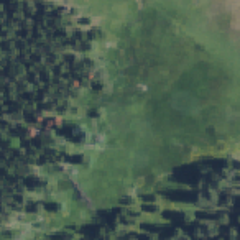

In [50]:
naip_coll = Catalog.from_file("stac/catalog/catalog.json").get_child("naip")
item = list(naip_coll.get_items())[0]
Image(item.assets["thumbnail"].href)